In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


from torchvision import datasets, transforms

import helper

import matplotlib.pyplot as plt

## Load Image data + data augmentation

Note: data augmentation usually only applied to the training data set, not test set

In [ ]:
##data location
# --Cat_Dog_data
#   --train
#       --dog
#       --cat
#   --test
#       --dog
#       --cat
    
data_dir = "Cat_Dog_data" 

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.toTensor(),  ##transform data to tensor format
                                      transforms.Normalize([0.5, 0.5, 0,5],  ##list length=3 because has RGB three channels.
                                                           [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

#normalization passed in a list of mean and a list of standard deviations.
#each color channel will be normalized as:
# input[channel] = (input[channel] - mean[channel])/std(channel)


train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)


In [40]:
#use exisiting data set as example, no data augmentation

transform = transforms.Compose([transforms.ToTensor()])  #data has only one channel:grey

trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download = True, train = True, transform = transform)
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data", download = True, train = False, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(9)


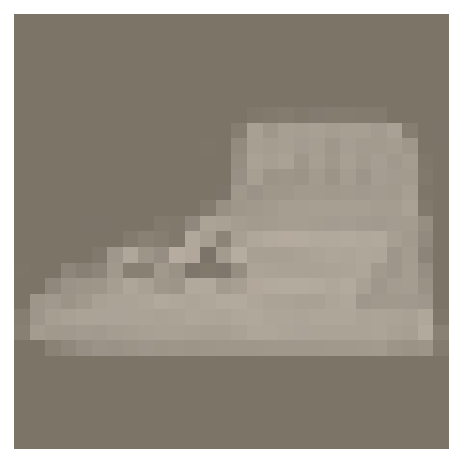

In [41]:
#check the image and label
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)
helper.imshow(images[0,:]);
print(labels[0])

## write NN in two ways

In [96]:
##build NN two different ways

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p = 0.2)  ##dropout rate = 0.2
    def forward(self, x):
        x = x.view(x.shape[0], -1)  #flatten the input from (64, 1, 28, 28) to (64, 784)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc2(x)))  #compbine the drop with relu activation and fc2
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x
    
##while usage:
# model = Classifier()
# output = model(input_images)

#global model ???

model = Classifier()
model #check model strucutre


Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [43]:
##second way:

# model = nn.Sequential(nn.Linear(784, 256),
#                       nn.ReLU(),
#                       nn.Dropout(0.2),
#                       nn.Linear(256, 128),
#                       nn.ReLU(),
#                       nn.Dropout(0.2),
#                       nn.Linear(128, 64),
#                       nn.ReLU(),
#                       nn.Dropout(0.2),
#                       nn.Linear(64, 10),
#                       nn.LogSoftmax(dim = 1))

# model  #print out model structure

##while usage:
#output = model.forward(input_images)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax()
)

## train model, test model

In [97]:
#criterion = nn.CrossEntropyLoss()  #binary classification
criterion = nn.NLLLoss()  #softmax, multi-classification

optimizer = optim.Adam(model.parameters(), lr = 0.003) 

epochs = 2

train_losses = []
test_losses = []

for e in range(epochs):
    train_loss = 0
    
    for images, labels in trainloader:
        
        optimizer.zero_grad() ##clear the gradient from last epoch, otherwise, it will be accumulate
        
        #train first model
        output = model(images)
        
        ##train second model 
        #images = images.view(images.shape[0], -1)  #if use first model, no need of this step
        #output = model.forward(images) #image will be falttened within the model structure
        
        loss = criterion(output, labels) #calculate train loss
        loss.backward() #backpropagation
        optimizer.step() #update gradient/weights
        
        train_loss += loss.item()
        
    else:  ##after for loop, keep running here for loss
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():  #do not update parameters
            
            model.eval()  #another way to set up: no update of parameters
            
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)  ##probability
                top_p, top_class = ps.topk(1, dim = 1) #pick the class with highest probabilty
                equals = top_class == labels.view(*top_class.shape)  #compare predicted class and labels. need to reshape label
                accuracy += torch.mean(equals.type(torch.FloatTensor)) #change data type to tensor
        
        model.train() ##go back to training condition for next epoch
        ##after one epoch
        train_losses.append(train_loss/len(trainloader)) ##summarize per epoch
        test_losses.append(test_loss/len(testloader))
        
        #print results per epoch
        print("Epoch: {}/{}..".format(e+1, epochs),
              "trainig loss: {:.3f}..".format(test_loss/len(trainloader)),
              "test loss:{:.3f}..".format(test_loss/len(testloader)),
              "test accuracy: {:.3f}..".format(accuracy/len(testloader)))
        

Epoch: 1/2.. trainig loss: 0.079.. test loss:0.472.. test accuracy: 0.824..
Epoch: 2/2.. trainig loss: 0.068.. test loss:0.409.. test accuracy: 0.855..


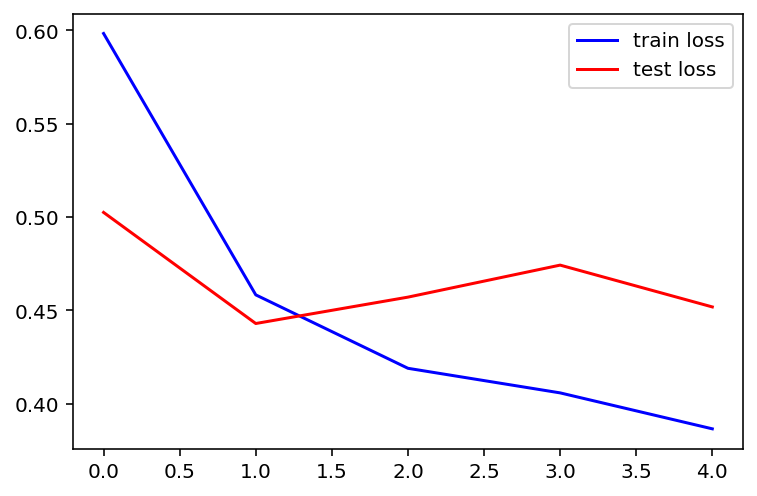

In [55]:
plt.plot(list(range(5)), train_losses, color = "blue", label = "train loss")
plt.plot(list(range(5)), test_losses, color = "red", label = "test loss")
plt.legend()

## Inference, check results

In [98]:
model.eval() #evaluation condition

dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = next(int(testloader)) #the same as above

img = images[0] #pick first image
img = img.view(1, 784)  #flatten

with torch.no_grad():
    log_ps = model(img)

ps = torch.exp(log_ps)
print(ps) #the 8th has highest probability

tensor([[3.5083e-06, 5.8574e-06, 1.6288e-01, 2.0293e-05, 7.9169e-01, 1.7063e-09,
         4.5384e-02, 1.1807e-10, 1.9251e-05, 1.2756e-08]])


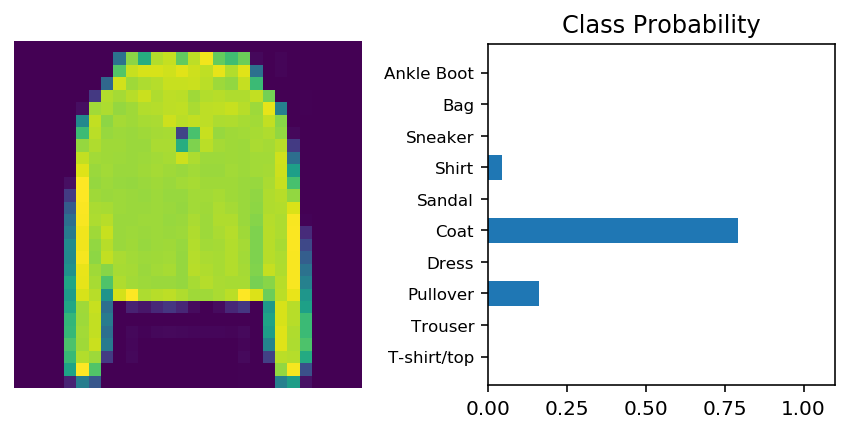

In [99]:
helper.view_classify(img.view(1, 28, 28), ps, version = "Fashion")

## save model and re-load

In [100]:
print("Our model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [102]:
#save the model strucutre together

checkpoint = {"input_size": 784,
              "output_size": 10,
              "hidden_layers": [256, 128, 64], 
              "state_dict": model.state_dict()}  #this state_dict() are the keys to store the weights and bias value
torch.save(checkpoint, "checkpoint.pth")

In [103]:
#reload. There is bit problem while reload this
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    global model
    model = model.Classifier(checkpoint["input_size"],
                          checkpoint["output_size"],
                          checkpoint["hidden_layers"])
    model.load_state_dict(checkpoint["state_dict"])
    
    return model

In [104]:
load_model = load_checkpoint("checkpoint.pth")
load_model

AttributeError: 'Classifier' object has no attribute 'Classifier'

## transfer learning + GPU
load pre-trained model, DO NOT update all trained parameters, but only train the final few steps which lead to your classifier.

In [105]:

from torchvision import models ##pre-trained model
model = models.resnet50(pretrained = True)  #load the pre-trained model resnet50
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\jenny.yang/.cache\torch\checkpoints\resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [106]:
##(fc): Linear(in_features=2048, out_features=1000, bias=True)

In [108]:
# trun off gradient. freeze trained parameters

for param in model.parameters():
    param.required_grad = False

    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                           ("fc1", nn.Linear(784, 128)),
                           ("relu1", nn.ReLU()),
                           ("drop1", nn.Dropout(0.2)),
                           ("fc2", nn.Linear(128, 10)),
                           ("output", nn.LogSoftmax(dim = 1))  #reduced the hidden layer number
                            ]))
model.classifier = classifier  ##add this classifier to the pre-trained model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#check if gpu avialable.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.01)  ###optimizer will only be applied to "new added classifier"

model.to(device) #use the "device"

epochs = 5

for e in range(epochs):
    for images, labels in trainloader:
        
        images, labels = images.to(device), labels.to(device)  #move the input data to correspodning device set up.
        
        ### all rest are the same